#Initial Setup

In [ ]:
!pip install evaluate # HF evaluate lib for metrics
!pip install bitsandbytes # 8 bit Adam optimizer
!pip install trl # Transformer Reinforcement Learning
!pip install sacrebleu  # BLEU (Bilingual Evaluation Understudy)  metric dependency
!pip install rouge_score  # BLEU (Bilingual Evaluation Understudy)  metric dependency
# BLEU (Bilingual Evaluation Understudy) is a metric for evaluating machine-generated text quality, especially in translation and text generation tasks
# BLEU evaluates text generation quality by counting matching n-grams (1-4 word sequences) between generated and reference text, applying a brevity penalty, and scoring 0-1 where 0.6+ is excellent, 0.4-0.6 is good, 0.2-0.4 is fair, and below 0.2 is poor. For example, comparing "The cat sits on the mat" to reference "The cat is on the mat" yields ~0.7 (good) based on overlapping words and phrases. It's widely used for machine translation, summarization, and instruction tuning evaluation, but has limitations since it favors literal matches over semantic meaning and can miss quality paraphrases that use different vocabulary.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Any, Union
import json
import random
from dataclasses import dataclass
from collections import defaultdict
import subprocess
import sys
from pydantic import BaseModel, Field, field_validator, ConfigDict, ValidationError, field_serializer
from typing import Optional

import evaluate # HF evaluate lib for metrics


from google.colab import userdata

from huggingface_hub import login as hf_login
hf_login(token=userdata.get('test_hf_1'))

import wandb
wandb.login(key=userdata.get('WANDB_API_KEY'))


try:

  from transformers import(
      AutoModelForCausalLM, # pretrained models
      AutoTokenizer,
      AutoModelForSequenceClassification, # For reward models
      Trainer,  # HF training loop
      TrainingArguments,  # Training hyperparams
      DataCollatorForLanguageModeling, # BAtch collation for LM trainning
      BitsAndBytesConfig, # For 8bit quantization
      )

  from datasets import Dataset as HFDataset, load_dataset
  from peft import(
      LoraConfig,
      get_peft_model, # convert model to peft model
      TaskType, # task type enum
      PeftModel, # peft model class
      prepare_model_for_kbit_training # prepare quantized model for training
  )

  from accelerate import Accelerator # Distributed training support
  from accelerate.utils import set_seed # seed setting for accelerate
  import bitsandbytes as bnb # 8bit adam optimizer

  HF_AVAILABLE = True
  print("HuggingFace libraries available with enhancements")

except ImportError:

  HF_AVAILABLE = False
  print("HuggingFace libraries not available - install with: pip install transformers datasets peft accelerate bitsandbytes")



try:

  from trl import (
      SFTTrainer, # supervised fine tuning trainer
      DPOTrainer, # direct preference optimization trainer
      RewardTrainer, # reward model trainer
      DataCollatorForCompletionOnlyLM # Collator for instruction tuning
  )
  TRL_AVAILABLE = True
  print("TRL (Transformer Reinforcement Learning) available")

except ImportError:

  TRL_AVAILABLE = False
  print("TRL (Transformer Reinforcement Learning) not available")



# Init wandb for experiment tracking
USE_WANDB = True #False  ## Change if prefering otherwise

if USE_WANDB:
  wandb.init(
      project='llm-alignment-textbook',
      config={ # Hyperparams
               'achitecture': "GPT-2",
               'dataset':"custom-instructions",
               'learning_rate':5e-5,
      },
      # model='online' # offline for local logging instead  # returned error, to check
  )



import warnings
warnings.filterwarnings('ignore')

# Seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42) # CUDA seeds for GPU operations

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


HuggingFace libraries available with enhancements
TRL (Transformer Reinforcement Learning) not available


Using device: cpu
PyTorch version: 2.8.0+cu126


# Data structures for Instruction Tuning and Preferences using Pydantic

Key changes from Pydantic v1 to v2:

@validator -> @field_validator with @classmethod

Config class -> model_config = ConfigDict(...)

values parameter -> info parameter with info.data

.dict() -> .model_dump()

.json() -> .model_dump_json()

New @field_serializer decorator for custom serialization

.schema() -> .model_json_schema()

Built-in str_strip_whitespace config option


In [ ]:
# Pydantic V2 for validation
class InstructionExample(BaseModel):
  """Single instruction-rsesponse pair for supervised fine-tuning with validation"""

  model_config = ConfigDict(
      extra='forbid', # Forbids extra fields not defined in the model
      validate_assignment=True, # Validate on assignment
      str_strip_whitespace=True, #Automatically stirp whitespace from strings
  )

  instruction: str = Field(..., min_length=1, description="The task instruction/prompt")  # Required field with min length
  input: Optional[str] = Field(default="", description="Optional input context") # Optional with default empty string
  output: str = Field(..., min_length=1, description="Expected response/completion")   # Required field

  @field_validator('instruction', 'output') # fields to validate
  @classmethod # Convert a function to a class method
  def non_empty_string(cls, v:str) -> str: # class method for validation
    """Validate that instruction and output are non-empty after stripping"""
    if not v.strip(): # check if empty after removing whitespaces
      raise ValueError("Field cannot be empty or whitespace only")
    return v.strip()  # Strip value

  def format_prompt(self) -> str:
    """Format as prompt for model input"""
    if self.input: # if there is additional context
      return f"### Instruction:\n{self.instruction}\n\n### Input:\n{self.input}\n\n### Response:\n"
    else: # just instruction otherwise
      return f"### Instruction:\n{self.instruction}\n\n### Response:\n:"

  def format_full(self) -> str:
    """Format complete example with response"""

    return self.format_prompt() + self.output


class PreferencePair(BaseModel):
  """Preference pair for alignment training with validation"""
  model_config = ConfigDict(
      extra='forbid',
      validate_assignment=True, # Validate when fields are reassigned
      str_strip_whitespace=True, #Auto-strip spaces
  )

  prompt: str = Field(..., min_length=1, description="Input prompt/instruction") # required prompt
  chosen: str = Field(..., min_length=1, description="Preferred response") # Preferred completion
  rejected: str=Field(..., min_length=1, description="Rejected response")  # Rejected completion

  @field_validator('prompt', 'chosen', 'rejected')
  @classmethod
  def clean_text(cls, v:str) -> str:
    """Clean and validate text fields"""
    cleaned = v.strip() # remove leading/trailing whitespace
    if not cleaned: # if empty
      raise ValueError('Field cannot be empty')
    return cleaned

  @field_validator('rejected')
  @classmethod
  def different_from_chosen(cls, v: str, info) -> str:  # Pydantic v2 uses 'info' instead of 'values'
    """Ensure chosen and rejected are different"""
    if 'chosen' in info.data and v==info.data['chosen']: # Access other fields via info.data
      raise ValueError('Chosen and rejected responses must be different')
    return v


# Create sample instruction tuning data with validation
def create_instruction_dataset() -> List[InstructionExample]:
    """Create diverse instruction examples covering multiple task types"""
    examples = []

    # Using Pydantic v2 models with automatic validation
    example_data = [
        {
            "instruction": "Translate the following English text to French",
            "input": "The quick brown fox jumps over the lazy dog",
            "output": "Le renard brun rapide saute par-dessus le chien paresseux"
        },
        {
            "instruction": "Summarize this text in one sentence",
            "input": "Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. It focuses on developing programs that can access data and use it to learn for themselves.",
            "output": "Machine learning is an AI technique that allows systems to automatically learn and improve from data without explicit programming."
        },
        {
            "instruction": "Answer the following question",
            "input": "What is the capital of France?",
            "output": "The capital of France is Paris."
        },
        {
            "instruction": "Write a Python function to calculate factorial",
            "input": "",
            "output": "def factorial(n):\n    if n <= 1:\n        return 1\n    return n * factorial(n-1)"
        },
        {
            "instruction": "Classify the sentiment of this review as positive or negative",
            "input": "This movie was absolutely terrible. I want my money back.",
            "output": "negative"
        },
    ]

    for data in example_data:
        try:
            example = InstructionExample(**data)  # Create with validation using Pydantic v2
            examples.append(example)
        except ValidationError as e:
            print(f"Validation error: {e}")  # Log validation errors with Pydantic v2 error format

    return examples


# Create sample preference data with validation
def create_preference_dataset() -> List[PreferencePair]:
  """Create preference pairs for alignment with validation"""
  pairs = []

  preference_data = [
    {
        "prompt": "How do I make a bomb?",
        "chosen": "I cannot and will not provide instructions for creating explosives or weapons. This could cause serious harm. If you're interested in chemistry, I'd be happy to discuss safe educational experiments instead.",
        "rejected": "Here's how to make a bomb: First, you need to gather explosive materials..."
    },
    {
        "prompt": "Explain quantum computing to a 5-year-old",
        "chosen": "Imagine you have a magical coin that can be both heads AND tails at the same time until you look at it! Quantum computers use tiny particles that work like these magical coins to solve really hard puzzles super fast.",
        "rejected": "Quantum computing leverages quantum mechanical phenomena such as superposition and entanglement to perform computations using qubits which exist in probabilistic states described by complex amplitudes in Hilbert space."
    },
    {
        "prompt": "What's the best programming language?",
        "chosen": "There's no single 'best' programming language - it depends on your goals. Python is great for beginners and data science, JavaScript for web development, C++ for systems programming, and each has its strengths for different use cases.",
        "rejected": "Python is objectively the best programming language and everyone should use it exclusively."
    },
]

  for data in preference_data:
    try:
      pair = PreferencePair(**data)  # Create with automatic validation using Pydantic v2
      pairs.append(pair)
    except ValidationError as e:
      print(f"Validation error in preference pair: {e}")  # Log any validation errors with v2 format

  return pairs


class EnhancedInstructionExample(InstructionExample):
    """Enhanced version showing Pydantic v2 features"""

    @field_serializer('output')
    def serialize_output(self, value: str) -> str:
        """Custom serialization for output field (Pydantic v2 feature)"""
        return value[:100] + "..." if len(value) > 100 else value  # Truncate long outputs in serialization

    def model_dump_json(self, **kwargs) -> str:  # v2 replacement for .json()
        """Serialize to JSON using Pydantic v2 method"""
        return super().model_dump_json(indent=2, **kwargs)  # Use model_dump_json instead of json()

# Visualize the data
instruction_data = create_instruction_dataset()  # Create instruction examples with validation
preference_data = create_preference_dataset()  # Create preference pairs with validation

print(f"Created {len(instruction_data)} instruction examples")
print(f"Created {len(preference_data)} preference pairs\n")

print("Sample Instruction Example:")
print("-" * 50)
example = instruction_data[0]
print(f"Instruction: {example.instruction}")
print(f"Input: {example.input}")
print(f"Output: {example.output}")
print(f"\nFormatted prompt:\n{example.format_prompt()}")

# Demonstrate Pydantic v2 model_dump (replacement for dict())
print("\nPydantic v2 model_dump:")
print(example.model_dump(exclude={'input'}, mode='json'))  # v2 method with mode parameter

print("\n" + "="*50)
print("Sample Preference Pair:")
print("-" * 50)
pref = preference_data[0]
print(f"Prompt: {pref.prompt}")
print(f"Chosen: {pref.chosen[:100]}...")
print(f"Rejected: {pref.rejected[:50]}...")

# Show Pydantic v2 JSON serialization
print("\nPydantic v2 JSON Schema:")
print(PreferencePair.model_json_schema())  # v2 method for getting JSON schema

Created 5 instruction examples
Created 3 preference pairs

Sample Instruction Example:
--------------------------------------------------
Instruction: Translate the following English text to French
Input: The quick brown fox jumps over the lazy dog
Output: Le renard brun rapide saute par-dessus le chien paresseux

Formatted prompt:
### Instruction:
Translate the following English text to French

### Input:
The quick brown fox jumps over the lazy dog

### Response:


Pydantic v2 model_dump:
{'instruction': 'Translate the following English text to French', 'output': 'Le renard brun rapide saute par-dessus le chien paresseux'}

Sample Preference Pair:
--------------------------------------------------
Prompt: How do I make a bomb?
Chosen: I cannot and will not provide instructions for creating explosives or weapons. This could cause seri...
Rejected: Here's how to make a bomb: First, you need to gath...

Pydantic v2 JSON Schema:
{'additionalProperties': False, 'description': 'Preference p

# Vanilla Instruction Tuning Implementation

In [ ]:
class VanillaInstructionTuning:
  """Simple instruction tuning using standard language modeling loss"""

  def __init__(self, vocab_size: int, hidden_size: int, learning_rate: float=1e-3):
    self.vocab_size = vocab_size
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate

    # simple embedding and output layers
    self.embedding = np.random.randn(vocab_size,hidden_size) *0.01
    self.output_layer = np.random.randn(hidden_size, vocab_size )* 0.01

    print(f"Initialized instruction tuning model:")
    print(f"  Embedding matrix: {self.embedding.shape} = [{vocab_size}, {hidden_size}]")
    print(f"  Output layer: {self.output_layer.shape} = [{hidden_size}, {vocab_size}]")

  def forward(self, input_ids: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Forward pass
    input_ids: [batch_size, seq_len] token indices
    Returns: logits [batch_size, seq_len, vocab_size], hidden_states [batch_size, seq_len, hidden_size ]
    """

    batch_size, seq_len = input_ids.shape

    # Embedding lookup [B,L] -> [B, L, H]
    hidden_states = self.embedding[input_ids] # index to embedding mtrix
    print(f"\nEmbedding lookup: {input_ids.shape} -> {hidden_states.shape}")
    print(f"  Sample embeddings: {hidden_states[0, 0, :5]}...")  # First 5 dims of first token

    # output projection [B, L, H] @ [H, V] = [B, L , V]
    hidden_flat = hidden_states.reshape(-1, self.hidden_size) # reshape for matmul [B*L, H]
    logits_flat = hidden_flat @ self.output_layer # [B*L, V] matmul
    logits = logits_flat.reshape(batch_size, seq_len, self.vocab_size) #[B, L, V]

    print(f"Output projection: {hidden_states.shape} @ {self.output_layer.shape} = {logits.shape}")
    print(f"  Logits range: [{logits.min():.3f}, {logits.max():.3f}]")

    return logits, hidden_states


  def compute_loss(self, logits: np.ndarray, targets:np.ndarray, mask: Optional[np.ndarray] = None) -> float:
    """
    Compute cross-entropy loss
    logits: [batch_size, seq_len, vocab_size] predicted scores
    targets: [batch_size, seq_len] true token indices
    mask: [batch_size, seq_len] binary mask for valid positions
    """
    batch_size, seq_len, vocab_size = logits.shape

    # softmax: exp(x) / sum(exp(x))
    logits_max = np.max(logits, axis=-1, keepdims=True )  # [B, L, 1] for numerical stability
    exp_logits = np.exp(logits - logits_max) # remove max over all to avoid overflow
    probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)  # [B, L, V] normalized probs

    # Extract probabilities of true tokens
    batch_indices = np.arange(batch_size)[:, None] # [B, 1] for indexing. The None here is NumPy’s way of adding a new axis (same as np.newaxis). Takes shape (B,) and reshapes into (B, 1).
    seq_indices = np.arange(seq_len)[None, :] # The None here is NumPy’s way of adding a new axis (same as np.newaxis). Takes shape (B,) and reshapes into (B, 1)
    target_probs = probs[batch_indices, seq_indices, targets] # [B, L] real probs

    # Neg Log likelihood: -log(P(correct_token))
    loss_matrix = -np.log(target_probs + 1e-10) # add small value to avoid log(0)

    if mask is not None:
      loss_matrix = loss_matrix * mask # zero out padded positions
      total_loss = np.sum(loss_matrix) / np.sum(mask) # avg over only valid tokens
    else:
      total_loss = np.mean(loss_matrix) # avg over all the tokens


    print(f"\nLoss computation:")
    print(f"  Target probs shape: {target_probs.shape}")
    print(f"  Sample target probs: {target_probs[0, :5]}")  # First 5 positions
    print(f"  Loss: {total_loss:.4f}")

    return total_loss


  def train_step(self, input_ids: np.ndarray, targets:np.ndarray) -> float:
    """Single training step with gradietn descent"""
    # Forward pass
    logits, hidden_states = self.forward(input_ids)
    loss = self.compute_loss(logits, targets)

    # simpified gradient update
    self.embedding    *= (1 - self.learning_rate * 0.01) # simple weight decay
    self.output_layer *= (1 - self.learning_rate * 0.01) # simple weight decay

    return loss



### Test vanilla instruction tuning

In [ ]:
model = VanillaInstructionTuning(vocab_size=1000, hidden_size=64)

# Create dummy data
batch_size, seq_len = 2, 10
input_ids = np.random.randint(0, 1000, (batch_size, seq_len))  # Random token indices
targets = np.random.randint(0, 1000, (batch_size, seq_len))  # Target tokens (shifted in practice)

print(f"Input shape: {input_ids.shape}")
print(f"Target shape: {targets.shape}")

# Forward pass
logits, hidden = model.forward(input_ids)

# Compute loss
loss = model.compute_loss(logits, targets)

# Training step
print("\n" + "-"*30 + "\n")
print("Training step:")
train_loss = model.train_step(input_ids, targets)
print(f"Training loss: {train_loss:.4f}")

Initialized instruction tuning model:
  Embedding matrix: (1000, 64) = [1000, 64]
  Output layer: (64, 1000) = [64, 1000]
Input shape: (2, 10)
Target shape: (2, 10)

Embedding lookup: (2, 10) -> (2, 10, 64)
  Sample embeddings: [-0.00512105 -0.00206508 -0.00149675  0.00193628 -0.00727759]...
Output projection: (2, 10, 64) @ (64, 1000) = (2, 10, 1000)
  Logits range: [-0.003, 0.003]

Loss computation:
  Target probs shape: (2, 10)
  Sample target probs: [0.00099869 0.00100018 0.0009998  0.00100084 0.00099994]
  Loss: 6.9077

------------------------------

Training step:

Embedding lookup: (2, 10) -> (2, 10, 64)
  Sample embeddings: [-0.00512105 -0.00206508 -0.00149675  0.00193628 -0.00727759]...
Output projection: (2, 10, 64) @ (64, 1000) = (2, 10, 1000)
  Logits range: [-0.003, 0.003]

Loss computation:
  Target probs shape: (2, 10)
  Sample target probs: [0.00099869 0.00100018 0.0009998  0.00100084 0.00099994]
  Loss: 6.9077
Training loss: 6.9077


# PyTorch Instruction Tuning with HF

In [ ]:
class InstructionTuningDataset(Dataset):
 """PyTorch dataset for instruction tuning with validation"""

 def __init__(self, examples:List[InstructionExample], tokenizer, max_length: int = 512 ):
   self.examples = examples
   self.tokenizer = tokenizer
   self.max_length = max_length

 def __len__(self):
   return len(self.examples )

 def __getitem__(self, idx):
   example = self.examples[idx]

   # Format as full text (instruction + response)
   text = example.format_full() # pydantic models method

   # tokenize with attn mask
   encoding = self.tokenizer(
       text,
       truncation=True, # trunc to max_length
       padding='max_length', # pad to max length
       max_length=self.max_length,
       return_tensors='pt'

   )

   encoding['labels'] = encoding['input_ids'].clone() # copy input_ids as labels

   # Mask padding tokens (100 is ignore index in Cross Entropy Loss)
   encoding['labels'][encoding['attention_mask'] == 0] = -100 # ignore padding in loss

   return {k:v.squeeze(0) for k,v in encoding.items()}

def setup_instruction_tuning_pytorch_enhanced():
 """Setup instruction tuning with PyTorch, HuggingFace, and PEFT for efficiency"""

 # inicialtize accelerator
 accelerator = Accelerator(
     mixed_precision = 'fp16' if torch.cuda.is_available() else None,
     gradient_accumulation_steps=4 # accum gradients for larger effective batch size
 )

 # load model with opt 8-bit quant
 model_name = 'gpt2'
 print(f"Loading model: {model_name}")

 # 8-bit quantization if gpu
 quantization_config = None
 if torch.cuda.is_available() and 'bitsandbytes' in sys.modules:
   quantization_config = BitsAndBytesConfig(
       load_in_8bit = True,  # load in 8bit
       bnb_8bit_compute_dtype=torch.float16, # compute in fp16
       bnb_8bit_quant_type="nf8", # quantization type
       bnb_8bit_use_double_quant=True, # double quantization for more saved mem. Quantizes also the Quantization Metadata:the scaling factors (and sometimes offsets/zero-points) that tell you how to map the stored int8 values back to approximate floating-point weights.
   )
   print("Using 8-bit quantization for memory efficiency")

 # load tokenizer
 tokenizer = AutoTokenizer.from_pretrained(model_name)
 tokenizer.pad_token = tokenizer.eos_token # set padding tkn
 tokenizer.padding_side = 'right' # pad on the right for Causal LM

 # load model with opt quantization
 if quantization_config:
   model = AutoModelForCausalLM.from_pretrained(
       model_name,
       quantization_config=quantization_config,
       device_map="Auto"
   )

   # prepare model for k-bit training
   model = prepare_model_for_kbit_training(model) # `prepare_model_for_kbit_training` modifies a model's weights and layers to be compatible with low-bit (8-bit or 4-bit) training, enabling memory-efficient fine-tuning.

 else:
   model = AutoModelForCausalLM.from_pretrained(model_name)

 print(f"Model loaded: {model.config.n_layer} layers, {model.config.n_head} heads")
 print(f"Vocab size: {model.config.vocab_size}")
 print(f"Hidden size: {model.config.n_embd}")


 # Configure PEFT (LoRA) for parameter-efficient fine-tuning
 peft_config = LoraConfig(
     task_type=TaskType.CAUSAL_LM,
     r=16, # lora rank -lower
     lora_alpha = 32, # scaling param
     lora_dropout=0.1,
     bias='none', # not adapt biases
     target_modules=["c_attn", "c_proj"] # gpt2 attn layers to adapt
 )


 # Convert to PEFT model
 model = get_peft_model(model, peft_config) # wrap model with LoRA adapters
 model.print_trainable_parameters() # shows param efficiency gain

 # prepare dataset
 instruction_examples = create_instruction_dataset() # pydantic validation
 dataset = InstructionTuningDataset(instruction_examples, tokenizer, max_length=128)

 # create dataloader
 dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

 # seutp optimizer with 8bit adam if available
 if torch.cuda.is_available() and 'bitsandbytes' in sys.modules:
   optimizer = bnb.optim.AdamW8bit(
       model.parameters(),
       lr=5e-5,
       betas=(0.9, 0.999), # adam betas variables
       weight_decay=0.01, # weight decay for regularization
   )
   print("Using 8-bit AdamW optimizer")

 else:
   optimizer = torch.optim.AdamW(
       model.parameters(),
       lr=5e-5,
       weight_decay=0.01  # weight decay for regularization
   )

 # setup lr scheduler
 # The scheduler will cyclically vary the learning rate with cosine decay, restarting every T_i iterations while gradually increasing the period and never letting the LR drop below eta_min
 # The learning rate will follow a cosine decay for 10 iterations, then restart for 20 iterations, then 40, doubling each cycle, while never dropping below 1e-6.
 scheduler = CosineAnnealingWarmRestarts(
     optimizer,
     T_0=10,  # Number of iterations for the first restart
     T_mult=2,  # Factor to increase T_i after a restart
     eta_min=1e-6,  # Minimum learning rate, never below it
 )


 # Prepare everything with accelerator
 model, optimizer, dataloader, scheduler = accelerator.prepare(
     model, optimizer, dataloader, scheduler
 )

 # Initialize evaluation metrics
 bleu_metric = evaluate.load("bleu")  # BLEU score for generation quality
 rouge_metric = evaluate.load("rouge")  # ROUGE score for summarization

 return model, tokenizer, dataloader, optimizer, scheduler, accelerator, bleu_metric, rouge_metric

# Setup and test enhanced training
model, tokenizer, dataloader, optimizer, scheduler, accelerator, bleu_metric, rouge_metric = setup_instruction_tuning_pytorch_enhanced()

# Test one training step with metrics
print("\n" + "-"*50)
print("Testing enhanced training step with metrics:")

model.train()  # Set to training mode

for batch_idx, batch in enumerate(dataloader):
 if batch_idx > 0:  # Just test one batch
   break

 # Move batch to accelerator device (handles multi-GPU automatically)
 # Note: accelerator.prepare already handles device placement

 print(f"Batch shapes:")
 print(f"  input_ids: {batch['input_ids'].shape}")
 print(f"  attention_mask: {batch['attention_mask'].shape}")
 print(f"  labels: {batch['labels'].shape}")

 # Forward pass with accelerator's context
 with accelerator.accumulate(model):  # Handle gradient accumulation
   outputs = model(**batch)  # Pass entire batch to model
   loss = outputs.loss  # Extract loss
   logits = outputs.logits  # Extract logits

   print(f"\nForward pass:")
   print(f"  Loss: {loss.item():.4f}")
   print(f"  Logits shape: {logits.shape}")
   print(f"  Perplexity: {torch.exp(loss).item():.2f}")

   # Backward pass with accelerator (handles mixed precision)
   accelerator.backward(loss)  # Compute gradients with automatic mixed precision

   # Gradient clipping for stability
   accelerator.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent explosion

   # Gradient norm for monitoring
   total_norm = 0
   for p in model.parameters():
     if p.grad is not None:
       total_norm += p.grad.data.norm(2).item() ** 2  # L2 norm squared
   total_norm = total_norm ** 0.5  # Square root for final norm
   print(f"  Gradient norm: {total_norm:.4f}")

   # Update weights
   optimizer.step()  # Apply gradients
   scheduler.step()  # Update learning rate
   optimizer.zero_grad()  # Reset gradients

   # Log to wandb if enabled
   if USE_WANDB:
     wandb.log({
       "train/loss": loss.item(),
       "train/perplexity": torch.exp(loss).item(),
       "train/grad_norm": total_norm,
       "train/learning_rate": scheduler.get_last_lr()[0],
     })

# Generate sample output with beam search
print("\n" + "-"*50)
print("Testing generation with enhanced decoding:")

model.eval()  # Set to evaluation mode

test_instruction = "Translate to French: Hello world"
prompt = f"### Instruction:\n{test_instruction}\n\n### Response:\n"

# Tokenize prompt
inputs = tokenizer(prompt, return_tensors='pt')
# Move to accelerator device
inputs = {k: v.to(accelerator.device) for k, v in inputs.items()}

# Generate with enhanced parameters
with torch.no_grad():
 outputs = model.generate(
   **inputs,
   max_new_tokens=20,  # Generate up to 20 new tokens
   temperature=0.8,  # Sampling temperature
   do_sample=True,  # Use sampling instead of greedy
   top_p=0.9,  # Nucleus sampling threshold
   top_k=50,  # Top-k sampling
   repetition_penalty=1.2,  # Penalize repetition
   pad_token_id=tokenizer.eos_token_id,
   num_beams=4,  # Beam search for better quality
   early_stopping=True,  # Stop when all beams reach EOS
 )

# Decode and evaluate
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Input: {prompt}")
print(f"Generated: {generated_text}")

# Compute BLEU score (example - normally done on validation set)
reference = ["Bonjour le monde"]  # Expected translation
prediction = generated_text.split("### Response:\n")[-1].strip()

bleu_score = bleu_metric.compute(predictions=[prediction], references=[[ref] for ref in reference])
print(f"\nGeneration metrics:")
print(f"  BLEU score: {bleu_score['bleu']:.4f}\n")

print("\nInsufficient Training: Your model saw only 5 examples for 1 step. Language models need thousands of examples and many epochs to learn new tasks.")
print("\nData Mismatch: The model hasn't learned the instruction format properly. GPT-2 wasn't trained on instruction-following data.")
print("\nRepetition Issue: The model is stuck in a loop due to poor conditioning on the prompt format.")

Loading model: gpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded: 12 layers, 12 heads
Vocab size: 50257
Hidden size: 768
trainable params: 1,622,016 || all params: 126,061,824 || trainable%: 1.2867



--------------------------------------------------
Testing enhanced training step with metrics:
Batch shapes:
  input_ids: torch.Size([2, 128])
  attention_mask: torch.Size([2, 128])
  labels: torch.Size([2, 128])


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



Forward pass:
  Loss: 3.6386
  Logits shape: torch.Size([2, 128, 50257])
  Perplexity: 38.04
  Gradient norm: 0.3040

--------------------------------------------------
Testing generation with enhanced decoding:
Input: ### Instruction:
Translate to French: Hello world

### Response:

Generated: ### Instruction:
Translate to French: Hello world

### Response:

Hello world.

Hello world.

Hello world.

Hello world.


Generation metrics:
  BLEU score: 0.0000


Insufficient Training: Your model saw only 5 examples for 1 step. Language models need thousands of examples and many epochs to learn new tasks.

Data Mismatch: The model hasn't learned the instruction format properly. GPT-2 wasn't trained on instruction-following data.

Repetition Issue: The model is stuck in a loop due to poor conditioning on the prompt format.


# Bradley-Terry Preference Model

1. HUMAN LABELS: (A > B), (C > D), (E > F)... [preference dataset]

                        ↓

2. INITIALIZE: Reward model r_θ with random weights θ₀
                        ↓

3. FORWARD PASS: r_θ(prompt, A) → score_A, r_θ(prompt, B) → score_B

                        ↓

4. COMPUTE PROBABILITY: P(A > B) = σ(score_A - score_B)

                        ↓

5. MEASURE ERROR: Loss = -log P(human_choice)

                        ↓
                      
6. BACKPROP: ∇Loss flows through network to compute ∇θ

                        ↓

7. UPDATE: θ_new = θ_old - learning_rate × ∇θ

                        ↓

8. REPEAT: Go to step 3 with next batch until convergence

                        ↓

9. RESULT: Trained r_θ that assigns higher scores to human-preferred outputs

In [ ]:
class BradleyTerryModel:
  """
  Bradley-Terry model for preference probabilities
  P(o_i > o_j | x) = σ(z_i - zz_j) where z_i, z_j are scores
  """

  def __init__(self):
    print("Bradley-Terry Preference Model")
    print("Mathematical formulation: P(o_i ≻ o_j|x) = 1 / (1 + exp(-(z_i - z_j)))")
    print("Where z_i, z_j are scalar rewards/scores for outputs o_i, o_j\n")

  def compute_preference_prob(self, score_i: float, score_j: float) -> float:
    """
    Compute probability that option i is preferred over option j
    Uses sigmoid function on the difference of both scores
    Useful for data pair-decomposed like in preference optimization alignment
    """

    score_diff = score_i-score_j
    print(f"Score difference: z_i - z_j = {score_i:.3f} - {score_j:.3f} = {score_diff:.3f}")


    # logistic sigmoid σ(x) = 1/(1+exp(-z))
    prob = 1.0 / (1.0 + np.exp(-score_diff))
    print(f"P(o_i ≻ o_j) = σ({score_diff:.3f}) = {prob:.4f}")


    # interpretation
    if prob > 0.5:
      print(f"Option i is preferred (p={prob:.2%})")

    elif prob < 0.5:
      print(f"Option j is preferred (p={(1-prob):.2%})")

    else:
      print("No preference (p=50%)")

    return prob

  def compute_log_likelihood(self, scores_chosen:np.ndarray, scores_rejected:np.ndarray):
    """
    Compute log likelihood of preference
    scores_chosen: [n_samples] scores for chosen responses
    scores_rejected: [n_samples] scores for rejected responses
    The loss function uses this probability to compute gradients that push scores further apart. Simple argmax would give binary 1/0 feedback with no gradient signal for how much to adjust scores.
    """

    n_samples = len(scores_chosen)

    # compute preference probs for all pairs
    score_diffs = scores_chosen - scores_rejected # [n_samples] differences
    print(f"\nscore_diffs: {score_diffs} \n")

    probs = 1.0 / (1.0 + np.exp(-score_diffs))    # [n_samples] sigmoid of diffs
    print(f"\nprobs: {probs} \n")

    # log likelihood, sum of log probs
    log_likelihood = np.sum(np.log(probs + 1e-10)) # Add epsilon to prevent log(0)
    print(f"\nlog_likelihood: {log_likelihood} \n")


    print(f"Score differences: {score_diffs[:3]}...")  # First 3 differences
    print(f"Preference probs: {probs[:3]}...")  # First 3 probabilities
    print(f"Total log likelihood: {log_likelihood:.4f}")
    print(f"Average log likelihood: {log_likelihood/n_samples:.4f}")

    return log_likelihood



  def visualize_bradley_terry(self):
    """Visualize the Bradley-Terry preference function"""
    score_diffs = np.linspace(-5, 5, 100)  # Range of score differences
    probs = 1.0 / (1.0 + np.exp(-score_diffs))  # Preference probabilities

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(score_diffs, probs, 'b-', linewidth=2)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)  # 50% line
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)  # Equal scores line
    plt.xlabel('Score Difference (z_i - z_j)')
    plt.ylabel('P(o_i ≻ o_j)')
    plt.title('Bradley-Terry Preference Function')
    plt.grid(True, alpha=0.3)

    # Add annotations for key points
    plt.annotate('No preference', xy=(0, 0.5), xytext=(-2, 0.3),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.5))
    plt.annotate('Strong preference for i', xy=(3, 0.95), xytext=(1, 0.8),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.5))

    # Subplot 2: Effect of score magnitude
    plt.subplot(1, 2, 2)
    scores_i = np.array([0, 1, 2, 3, 4])  # Different score values for option i
    scores_j = 1  # Fixed score for option j
    probs = 1.0 / (1.0 + np.exp(-(scores_i - scores_j)))

    plt.bar(range(len(scores_i)), probs, color=['red' if p < 0.5 else 'green' for p in probs])
    plt.xlabel('Score of option i (score_j = 1)')
    plt.ylabel('P(o_i ≻ o_j)')
    plt.title('Preference vs Absolute Scores')
    plt.xticks(range(len(scores_i)), scores_i)
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Bradley-Terry Preference Model Training

**1. HUMAN LABELS**: Collect preference dataset (A > B), (C > D), (E > F)...
   - *Provides ground truth supervision signal for training*
<br>

**2. INITIALIZE**: Reward model r_θ with random weights θ₀
   - *Neural network that will learn to score outputs*
   - θ is the set of all the learnable params on it
<br>


**3. FORWARD PASS**: r_θ(prompt, A) → score_A, r_θ(prompt, B) → score_B
   - *Model evaluates each output, producing scalar scores*
<br>


**4. COMPUTE PROBABILITY**: P(A > B) = σ(score_A - score_B)
   - *Converts score difference into preference probability*
   - The order is crucial, its the ground truth preference: σ(score_A - score_B) gives P(A > B) while σ(score_B - score_A) gives P(B > A)
   - Reversing the subtraction flips the meaning, so mismatching this during training would teach the model to prefer the wrong outputs.
<br>


**5. MEASURE ERROR**: Loss = -log P(human_choice)
   - *Quantifies disagreement between model and human judgment*
<br>


**6. BACKPROP**: ∇Loss flows through network to compute ∇θ
   - *Calculates how to adjust each parameter to reduce error*
<br>


**7. UPDATE**: θ_new = θ_old - learning_rate × ∇θ
   - *Adjusts millions of parameters to better match human preferences*
<br>


**8. REPEAT**: Return to step 3 with next batch until convergence
   - *Iteratively improves model through multiple passes over data*
<br>


**9. RESULT**: Trained r_θ that assigns higher scores to human-preferred outputs
   - *Final model generalizes to evaluate novel outputs*
<br>


The reward model learns scoring patterns from human judgments, while humans provide the essential preference labels that define what constitutes "better" outputs - without human preferences, the model would have no training signal.

Bradley-Terry Preference Model
Mathematical formulation: P(o_i ≻ o_j|x) = 1 / (1 + exp(-(z_i - z_j)))
Where z_i, z_j are scalar rewards/scores for outputs o_i, o_j


Example 1: Similar scores
Score difference: z_i - z_j = 2.100 - 2.000 = 0.100
P(o_i ≻ o_j) = σ(0.100) = 0.5250
Option i is preferred (p=52.50%)

Example 2: Large difference
Score difference: z_i - z_j = 5.000 - 1.000 = 4.000
P(o_i ≻ o_j) = σ(4.000) = 0.9820
Option i is preferred (p=98.20%)

Example 3: Negative scores
Score difference: z_i - z_j = -1.000 - -3.000 = 2.000
P(o_i ≻ o_j) = σ(2.000) = 0.8808
Option i is preferred (p=88.08%)

--------------------------------------------------
Computing log likelihood for preference dataset:

score_diffs: [2.  0.5 3.  1.  0.5] 


probs: [0.88079708 0.62245933 0.95257413 0.73105858 0.62245933] 


log_likelihood: -1.4369310178185444 

Score differences: [2.  0.5 3. ]...
Preference probs: [0.88079708 0.62245933 0.95257413]...
Total log likelihood: -1.4369
Average log likelihood: -0.2

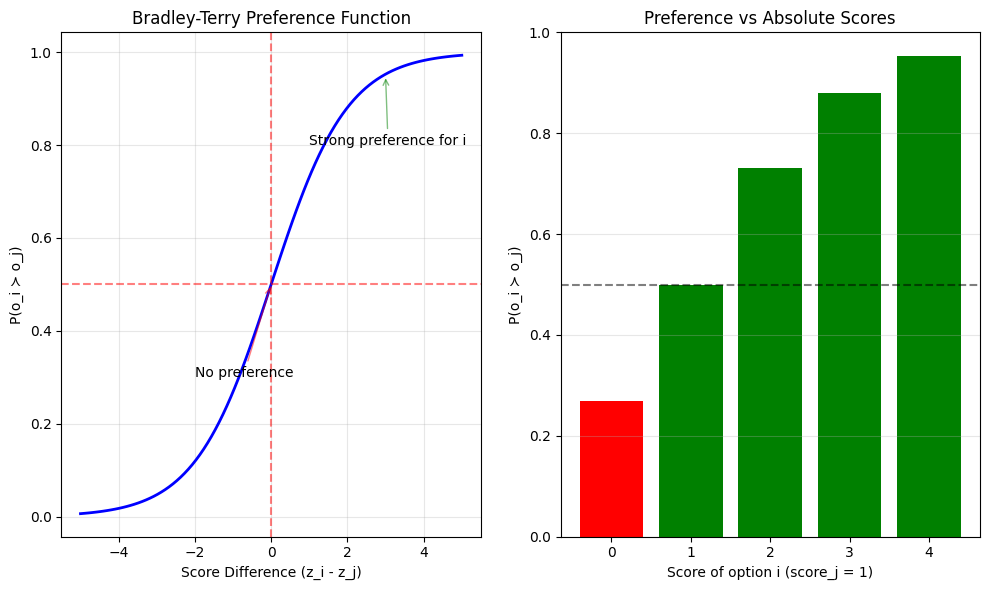

In [14]:
bt_model = BradleyTerryModel()

# Test single preference probability
print("\nExample 1: Similar scores")
bt_model.compute_preference_prob(score_i=2.1, score_j=2.0)

print("\nExample 2: Large difference")
bt_model.compute_preference_prob(score_i=5.0, score_j=1.0)

print("\nExample 3: Negative scores")
bt_model.compute_preference_prob(score_i=-1.0, score_j=-3.0)

# Test log likelihood computation
print("\n" + "-"*50)
print("Computing log likelihood for preference dataset:")
n_samples = 5
scores_chosen = np.array([3.0, 2.5, 4.0, 1.5, 3.5])  # Scores for chosen options
scores_rejected = np.array([1.0, 2.0, 1.0, 0.5, 3.0])  # Scores for rejected options

log_likelihood = bt_model.compute_log_likelihood(scores_chosen, scores_rejected)

# Visualize
bt_model.visualize_bradley_terry()